# Demo of a Jupyter notebook

- Let's see which day was the sunnier in 2017 on our campus
- With Python and weather data from https://darksky.net/dev/

## Dependencies

In [1]:
%load_ext watermark
%watermark -a "Lilian Besson (Naereen)" -i -v -p numpy,matplotlib

Lilian Besson (Naereen) 2018-03-07T18:59:05+01:00

CPython 3.6.3
IPython 6.2.1

numpy 1.14.1
matplotlib 2.1.2


In [2]:
from os.path import expanduser, join
from datetime import date, timedelta
from dateutil.parser import parse
from datetime import datetime as dt
from json import load, dump

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter

try:
    from darksky import forecast
except ImportError as e:
    print("Install 'darksky' module with 'pip install git+https://github.com/lukaskubis/darkskylib'...")
    raise e

## Get the data

In [3]:
def get_data(location, key, delay=365):
    thisday = date.today()
    oneday = timedelta(days=1)
    alldata = {}
    all_cloud_cover = {}
    for d in range(delay):
        t = thisday.isoformat()
        if 'T' not in t:
            t += 'T12:00:00'
        try:
            with forecast(key, *location, time=t) as weather:
                alldata[thisday] = weather
                all_cloud_cover[thisday] = weather["daily"]["data"][0]["cloudCover"]
                print("For the day", thisday, "the 'cloudCover' index was", all_cloud_cover[thisday])
        except:
                all_cloud_cover[thisday] = np.nan
                print("Missing data for", thisday, "so using a nan... it won't be included in the plots!")
        thisday = thisday - oneday
    return alldata, all_cloud_cover

We can try to be smart and load/backup the data if possible.

In [4]:
def save_data(all_cloud_cover, filename):
    new_dict = dict()
    for d, k in all_cloud_cover.items():
        new_dict[d.isoformat()] = k
    with open(filename, "w") as fp:
        dump(new_dict, fp)

In [5]:
def load_data(filename):
    with open(filename, "r") as fp:
        new_dict = load(fp)
        all_cloud_cover = dict()
        for d, k in new_dict.items():
            dt = parse(d.replace('T12:00:00', ''))
            all_cloud_cover[dt] = k
    return all_cloud_cover

See the data I already downloaded and extraded:

In [6]:
!ls -larth *.json

-rw-r--r-- 1 lilian lilian 7,1K janv. 25 14:07 all_cloud_cover__Briancon.json
-rw-r--r-- 1 lilian lilian 7,1K janv. 25 14:09 all_cloud_cover.json


## Plot the data

In [7]:
def plot_data(all_cloud_cover, name):
    Xs = np.array(list(all_cloud_cover.keys()))
    Ys = np.array(list(all_cloud_cover.values()))

    # Remove day where we couldn't find the data
    are_nans = np.isnan(Ys)
    Xs = Xs[~are_nans]
    Ys = Ys[~are_nans]

    fig, ax = plt.subplots()
    ax.set_title(f"Cloud cover index in {name}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cloud cover (0 is fully sunny, 1 is fully cloudy)")
    ax.plot_date(Xs, Ys, ms=5, marker='o', color='black')

    ax.fmt_xdata = DateFormatter('%Y-%m-%d')
    fig.autofmt_xdate()

    plt.show()

In [8]:
def plot_data_by_weekday(all_cloud_cover, name):
    count_of_weekday = np.zeros(7)
    data_by_weekday = np.zeros(7)
    mean_by_weekday = np.zeros(7)
    for x, y in all_cloud_cover.items():
        if not np.isnan(y):
            weekday = x.weekday()
            count_of_weekday[weekday] += 1
            data_by_weekday[weekday] += y
            # print("For weekday", weekday, "one more count with cloud_cover =", y)
    for weekday in range(7):
        mean_by_weekday[weekday] = data_by_weekday[weekday] / count_of_weekday[weekday]

    plt.figure()
    plt.title(f"Mean cloud cover index in {name}, in 2017")
    plt.xlabel("Day of the week")
    plt.ylabel("Mean cloud cover (0 is fully sunny, 1 is fully cloudy)")

    days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    x = np.arange(7)
    plt.bar(x, mean_by_weekday, color="gold")
    plt.xticks(x, days)
    plt.show()

## Do all this

In [9]:
# CentraleSupélec, campus of Rennes, France
name = "CentraleSupélec, Rennes"
# 48° 6' 36"N, 1° 40' 48"W
# https://www.google.fr/maps/place/Supélec/@48.1252316,-1.6255899,17z/
location = 48.1252316, -1.6255899

print("For localisation '{}' at location {}...".format(name, location))

For localisation 'CentraleSupélec, Rennes' at location (48.1252316, -1.6255899)...


In [10]:
# you need the Darksky API key
with open(join(expanduser("~"), ".darksky_api.key"), "r") as f:
    key = f.readline()

Now, try to load the data, or fetch it and save it:

In [11]:
try:
    print("Trying to load the data from 'all_cloud_cover.json' ...")
    all_cloud_cover = load_data("all_cloud_cover.json")
    print("Success in loading the data from 'all_cloud_cover.json' ...")
except:
    print("Failed to load the data from 'all_cloud_cover.json' ...")
    print("Using API to download data...")
    print(input("Enter to continue"))
    alldata, all_cloud_cover = get_data(location, key)
    print("Trying to save the data from 'all_cloud_cover.json' ...")
    save_data(all_cloud_cover, "all_cloud_cover.json")
    print("Success in saving the data from 'all_cloud_cover.json' ...")

Trying to load the data from 'all_cloud_cover.json' ...
Success in loading the data from 'all_cloud_cover.json' ...


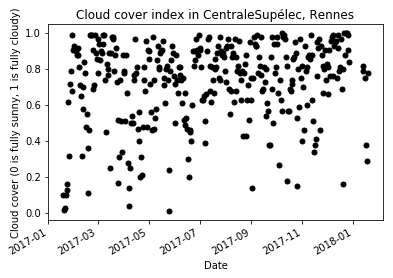

In [12]:
plot_data(all_cloud_cover, name)

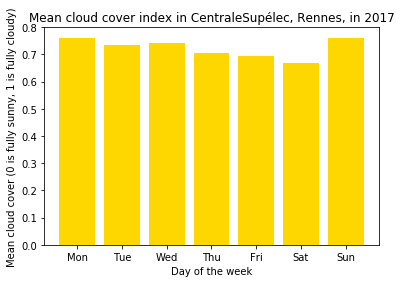

In [13]:
plot_data_by_weekday(all_cloud_cover, name)

## Conclusion

Hope you got a good overview of Jupyter notebooks.